### Import Packages 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from CESM_Utils import *

### Look at intake-esm catalog for CESM1 model

In [2]:
cat_url = "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json"
full_col = intake.open_esm_datastore(cat_url)
full_col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [3]:
full_col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,FLNSC,clearsky net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,FLUT,upwelling longwave flux at top of model,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,FSNS,net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,FSNSC,clearsky net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
...,...,...,...,...,...,...,...,...,...,...,...
437,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
438,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
439,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
440,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


### Get reference height temperature
Doing reference height temp so I dont have to deal with lev dimension. Is this the variable we would want to use? Could we use T variable and average over lev? 

In [4]:
# Define a query for temperature 
query = dict(
    variable=['TREFHT'],
    experiment=['RCP85'],
    frequency=['monthly']
)

In [5]:
# create a catalog for the temp variable only and view the catalog 
col = full_col.search(**query)
col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TREFHT,reference height temperature,atm,RCP85,monthly,1.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...


In [6]:
# load data into xarray datasets
dset = col.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [7]:
# Define temp dataset within dict
temp = dset['atm.RCP85.monthly']

In [8]:
temp = fix_lon_temp(data=temp)
data_global = get_global_data(data=temp)

In [9]:
# get regional data
USwest = get_local_data(data=temp,lat=37.7,lon=-122.4)   # san fran
USeast = get_local_data(data=temp,lat=41.3,lon=-72.5)    # clinton
iceland = get_local_data(data=temp,lat=65,lon=-19)
europe = get_local_data(data=temp,lat=51,lon=10.5)       # Germany 
australia = get_local_data(data=temp,lat=-25.2,lon=133.7)
tropics = get_local_data(data=temp,lat=3.9,lon=-53.1)    # french Guiana 

### Access 20C experiment to get reference data 

In [10]:
# Define a query for reference temperature 
query = dict(
    variable=['TREFHT'],
    experiment=['20C'],
    frequency=['monthly']
)

In [11]:
# create a catalog for the temp variable only 
col = full_col.search(**query)
# view the catalog
col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TREFHT,reference height temperature,atm,20C,monthly,1.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-TRE...


In [12]:
# load data into xarray datasets
dset = col.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [13]:
# define temp reference dataset 
temp_ref = dset['atm.20C.monthly']

In [14]:
temp_ref = fix_lon_temp(data=temp_ref)
data_ref_global = get_global_reference(data=temp_ref,year1='1985',year2='2005')

In [15]:
# # get regional reference data
USwest_ref = get_local_reference(data=temp_ref,lat=37.7,lon=-122.4,year1='1985',year2='2005')   # san fran
USeast_ref = get_local_reference(data=temp_ref,lat=41.3,lon=-72.5,year1='1985',year2='2005')    # clinton
iceland_ref = get_local_reference(data=temp_ref,lat=65,lon=-19,year1='1985',year2='2005')
europe_ref = get_local_reference(data=temp_ref,lat=51,lon=10.5,year1='1985',year2='2005')       # Germany 
australia_ref = get_local_reference(data=temp_ref,lat=-25.2,lon=133.7,year1='1985',year2='2005')
tropics_ref = get_local_reference(data=temp_ref,lat=3.9,lon=-53.1,year1='1985',year2='2005')    # french Guiana 

Question: we dont need to do any sort of rolling average to get reference data, right? 

### Calculate internal variability 
For the CESM1 large ensemble, only internal variability can be estimated. We cannot estimate model uncertainity because we are only working with one model. Internal variability can be calculated in two ways: using the HS09 method or the LE method. The HS09 method fits a fourth order polynomial to each ensemble member and estimates the internal variability as the variance across the fits. For the LE method, the int. variability is calculated as the variance across ensemble members (relative to ensemble mean)

### start with local data - single point

In [16]:
# calculate internal variability 
USwest = internal_variability(data=USwest,data_ref=USwest_ref,variable='TREFHT')
USeast = internal_variability(data=USeast,data_ref=USeast_ref,variable='TREFHT')
iceland = internal_variability(data=iceland,data_ref=iceland_ref,variable='TREFHT')
europe = internal_variability(data=europe,data_ref=europe_ref,variable='TREFHT')
australia = internal_variability(data=australia,data_ref=australia_ref,variable='TREFHT')
tropics = internal_variability(data=tropics,data_ref=tropics_ref,variable='TREFHT')

In [40]:
temp

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1140, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
Attributes: (12/14)
    Conventions:               CF-1.0
    NCO:                       4.3.4
    Version:                   $Name$
    host:                      tcs-f02n07
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i.2006-01-...
    ...                        ...
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...
    intake_esm_varname:        ['TREFHT']
    intake_esm_dataset_key:    atm.RCP85.monthly

In [42]:
temp.load().to_netcdf('/home/jupyter/data/CESM_TREFHT_data.nc') 

KeyboardInterrupt: 

In [18]:
# load saved regional datasets 
# USwest = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_USwest.nc')
# USeast = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_USeast.nc')
# iceland = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_iceland.nc')
# europe = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_europe.nc')
# australia = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_australia.nc')
# tropics = xr.open_dataset('/home/jupyter/data/CESM_IntVariability_tropics.nc')

Text(0.5, 1.0, '4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for Tropics')

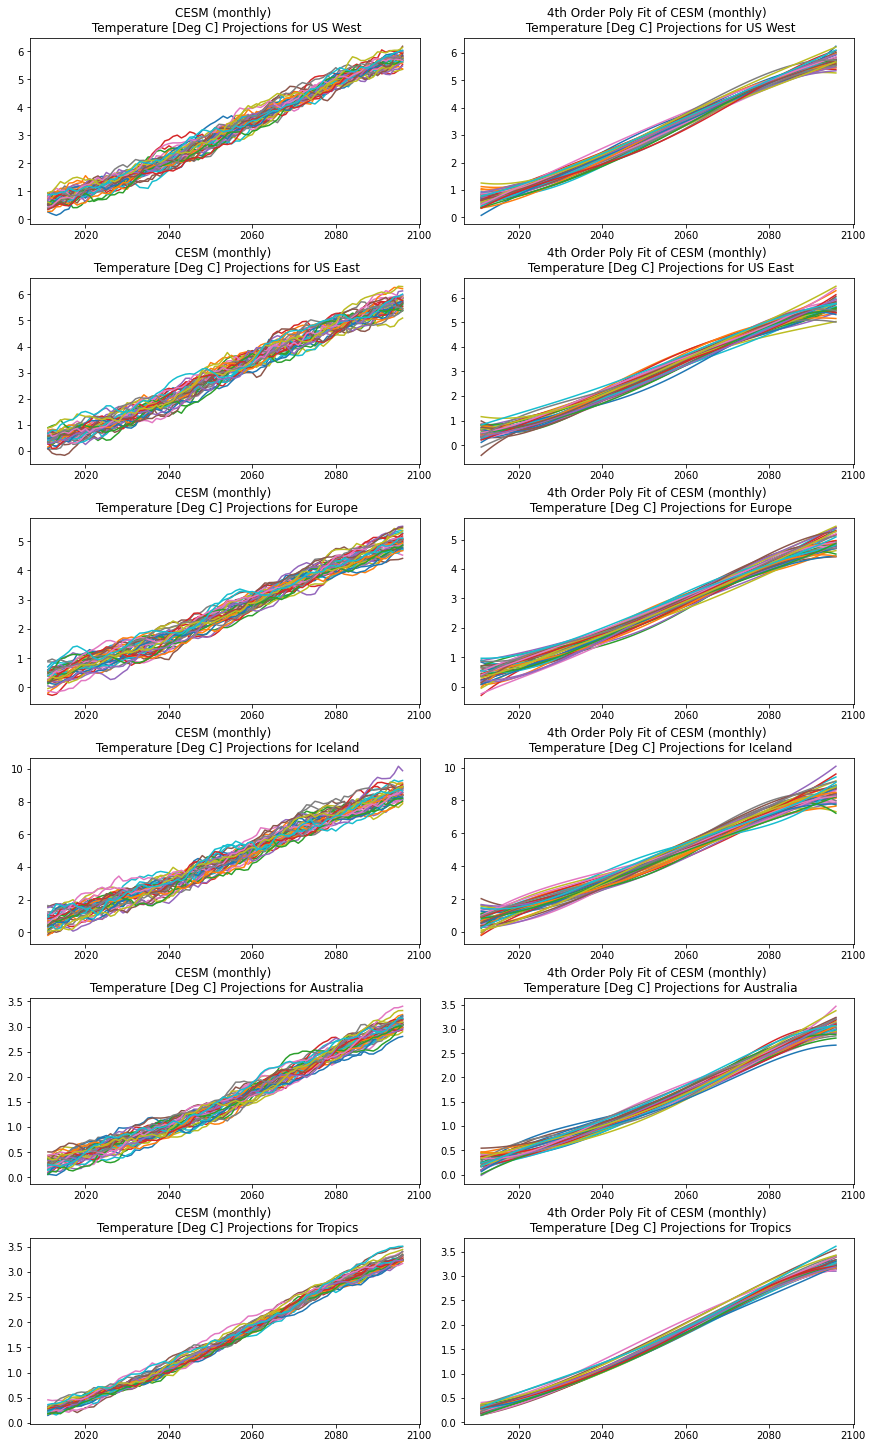

In [19]:
fig, ax = plt.subplots(nrows=6, ncols=2, constrained_layout=True,figsize=(12,20))
for i in range(len(USwest.member_id)):
    ax[0,0].plot(USwest.time.dt.year,USwest.TREFHT.isel(member_id=i))
    ax[0,1].plot(USwest.time.dt.year,USwest.TREFHT_fit.isel(member_id=i))
ax[0,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for US West')
ax[0,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for US West')
for i in range(len(USeast.member_id)):
    ax[1,0].plot(USeast.time.dt.year,USeast.TREFHT.isel(member_id=i))
    ax[1,1].plot(USeast.time.dt.year,USeast.TREFHT_fit.isel(member_id=i))
ax[1,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for US East')
ax[1,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for US East')
for i in range(len(europe.member_id)):
    ax[2,0].plot(europe.time.dt.year,europe.TREFHT.isel(member_id=i))
    ax[2,1].plot(europe.time.dt.year,europe.TREFHT_fit.isel(member_id=i))
ax[2,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for Europe')
ax[2,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for Europe')
for i in range(len(iceland.member_id)):
    ax[3,0].plot(iceland.time.dt.year,iceland.TREFHT.isel(member_id=i))
    ax[3,1].plot(iceland.time.dt.year,iceland.TREFHT_fit.isel(member_id=i))
ax[3,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for Iceland')
ax[3,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for Iceland')
for i in range(len(australia.member_id)):
    ax[4,0].plot(australia.time.dt.year,australia.TREFHT.isel(member_id=i))
    ax[4,1].plot(australia.time.dt.year,australia.TREFHT_fit.isel(member_id=i))
ax[4,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for Australia')
ax[4,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for Australia')
for i in range(len(tropics.member_id)):
    ax[5,0].plot(tropics.time.dt.year,tropics.TREFHT.isel(member_id=i))
    ax[5,1].plot(tropics.time.dt.year,tropics.TREFHT_fit.isel(member_id=i))
ax[5,0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for Tropics')
ax[5,1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for Tropics')

In [21]:
USwest

<xarray.Dataset>
Dimensions:       (time: 86, member_id: 40)
Coordinates:
  * time          (time) object 2011-01-01 00:00:00 ... 2096-01-01 00:00:00
    lat           float64 38.17
    lon           float64 -122.5
  * member_id     (member_id) int64 1 2 3 4 5 6 7 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT        (time, member_id) float64 0.664 0.8005 0.5364 ... 6.131 6.031
    TREFHT_ref    float32 16.53
    TREFHT_fit    (time, member_id) float64 0.7241 1.123 0.6672 ... 6.208 6.098
    internal_fit  float64 0.02095
    internal_le   (time) float64 0.03447 0.04388 0.04037 ... 0.03553 0.03227

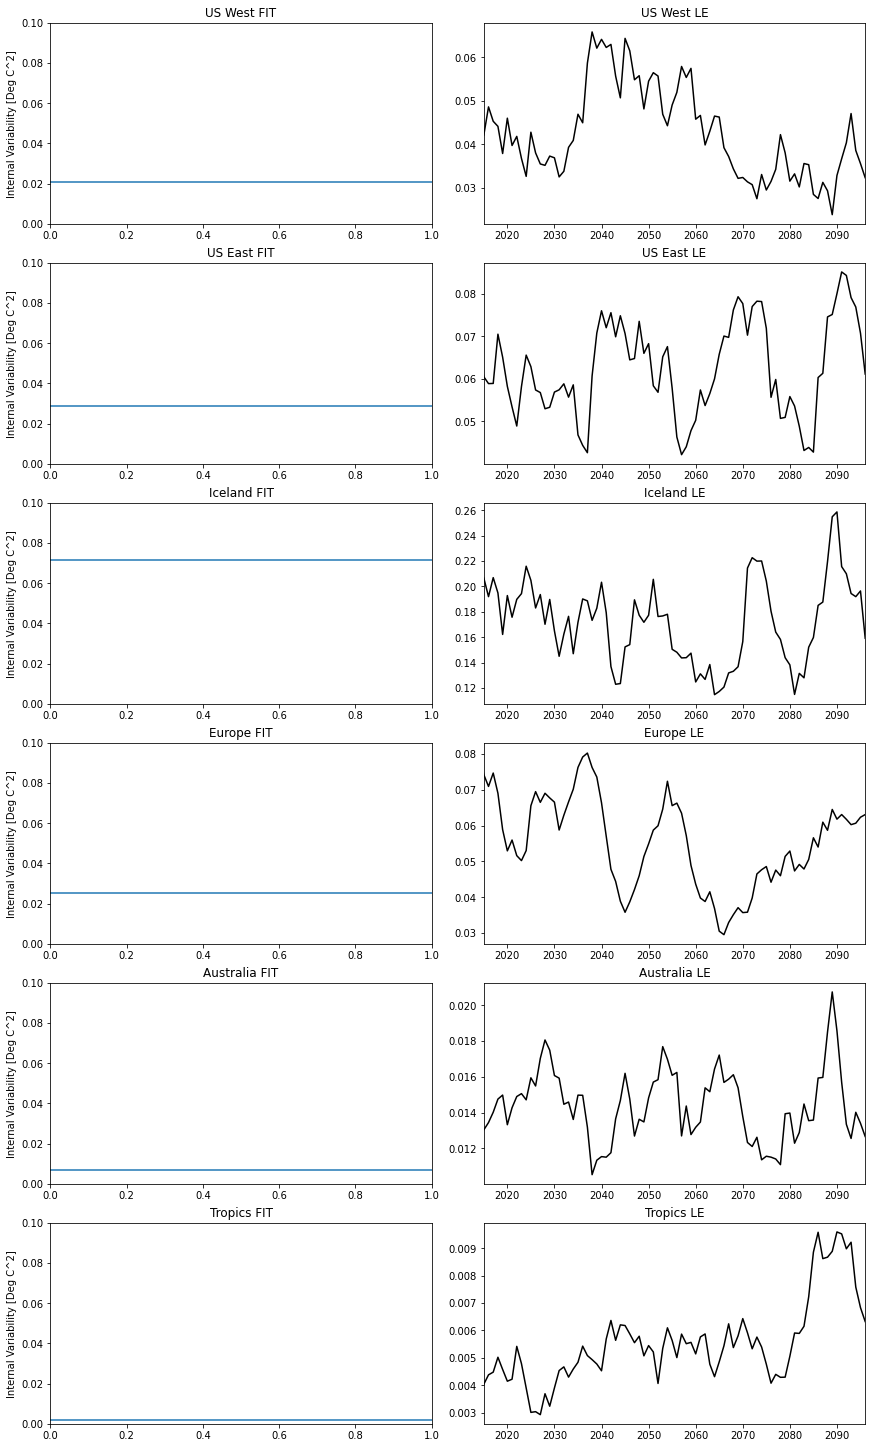

In [24]:
# plot internal variability from FIT method 
fig, ax = plt.subplots(nrows=6, ncols=2, constrained_layout=True,figsize=(12,20))

rows = np.arange(0,6,1)
regions = [USwest,USeast,iceland,europe,australia,tropics]
for i,region in zip(rows,regions):
    ax[i,0].axhline(region.internal_fit)  
    #ax[i,0].set_xlim(region.time.dt.year[4],region.time.dt.year[-1])
    ax[i,0].set_ylim(0,0.1)
    ax[i,0].set_ylabel('Internal Variability [Deg C^2]')
    ax[i,1].plot(region.time.dt.year,region.internal_le,color='k')
    ax[i,1].set_xlim(region.time.dt.year[4],region.time.dt.year[-1])
    
title_fit = ['US West FIT', 'US East FIT', 'Iceland FIT','Europe FIT','Australia FIT','Tropics FIT']
title_LE = ['US West LE', 'US East LE', 'Iceland LE','Europe LE','Australia LE','Tropics LE']

for i,j,k in zip(rows,title_fit,title_LE):
    ax[i,0].set_title(j)
    ax[i,1].set_title(k)

### Look at global data 

In [25]:
data_global = internal_variability(data=data_global,data_ref=data_ref_global,variable='TREFHT')

In [26]:
data_global

<xarray.Dataset>
Dimensions:       (time: 86, member_id: 40)
Coordinates:
  * time          (time) object 2011-01-01 00:00:00 ... 2096-01-01 00:00:00
  * member_id     (member_id) int64 1 2 3 4 5 6 7 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT        (time, member_id) float64 0.5003 0.5661 0.4483 ... 5.767 5.75
    TREFHT_ref    float32 3.647
    TREFHT_fit    (time, member_id) float64 0.6148 0.5358 0.5038 ... 5.764 5.772
    internal_fit  float64 0.002009
    internal_le   (time) float64 0.009325 0.008834 0.008354 ... 0.01431 0.01367

In [33]:
# data_global.to_netcdf('/home/jupyter/data/CESM_IntVariability_global.nc')

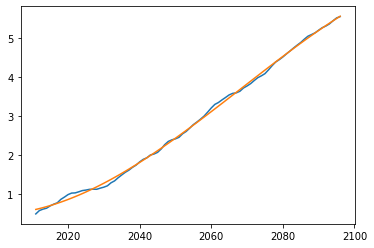

In [28]:
plt.plot(data_global.time.dt.year,data_global.TREFHT.isel(member_id=0))
plt.plot(data_global.time.dt.year,data_global.TREFHT_fit.isel(member_id=0))

Text(0.5, 1.0, '4th Order Poly Fit of CESM (monthly) \n Global Temperature [Deg C] Projections')

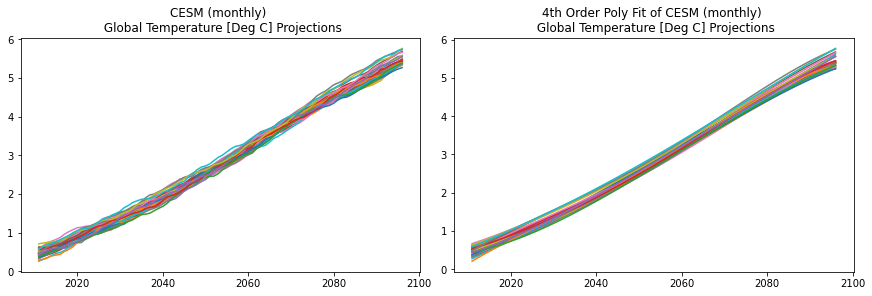

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data_global.member_id)):
    ax[0].plot(data_global.time.dt.year,data_global.TREFHT.isel(member_id=i))
    ax[1].plot(data_global.time.dt.year,data_global.TREFHT_fit.isel(member_id=i))
ax[0].set_title('CESM (monthly) \n Global Temperature [Deg C] Projections')
ax[1].set_title('4th Order Poly Fit of CESM (monthly) \n Global Temperature [Deg C] Projections')

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n Global Data via HS09')

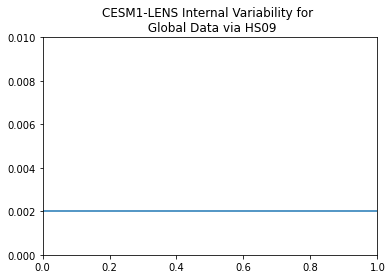

In [31]:
# x = data_global.time.dt.year
# plt.plot(data_global.time.dt.year,data_global.internal_fit,color='k')
plt.axhline(data_global.internal_fit)
plt.ylim(0,0.01)
# plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n Global Data via HS09')

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n Global Data via LE Method')

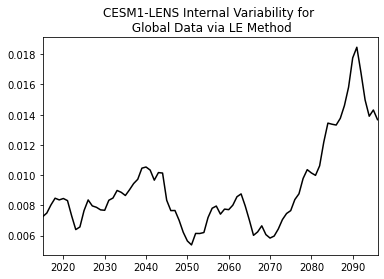

In [32]:
x = data_global.time.dt.year
plt.plot(data_global.time.dt.year,data_global.internal_le,color='k')
# plt.axhline(internal)
plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n Global Data via LE Method')